# drive mount


In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

%cd /content/drive/My Drive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN


# imports and installs


In [2]:
 import h5py
import torch
import numpy as np
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import time
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from utils import *
from dataset import *
from rpn import *
#from BoxHead import *
#from MaskHead import *

# ground truth visualization

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


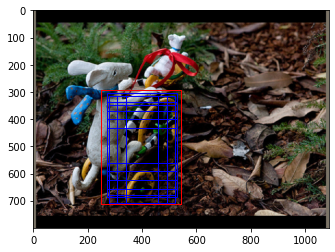

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


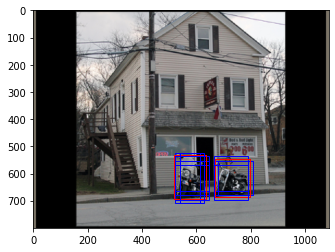

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


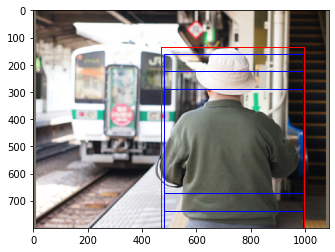

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


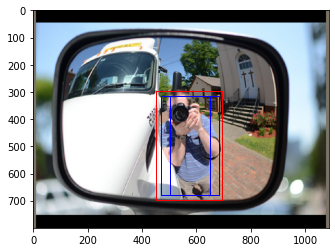

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


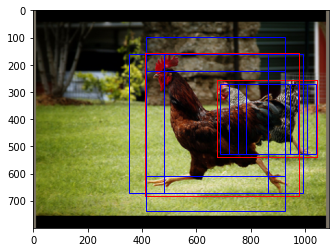

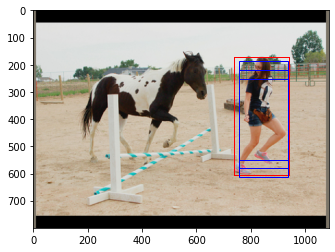

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


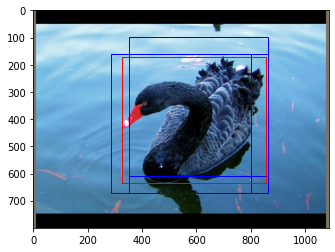

In [3]:
if __name__ == '__main__':
    # file path and make a list
    imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
    masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
    labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
    bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
    paths = [imgs_path, masks_path, labels_path, bboxes_path]
    # load the data into data.Dataset
    dataset = BuildDataset(paths)

  
    # build the dataloader
    # set 20% of the dataset as the training data
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    # random split the dataset into training and testset

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    rpn_net = RPNHead()
    # push the randomized training data into the dataloader
    batch_size = 1
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    train_loader = train_build_loader.loader()
    test_build_loader = BuildDataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    test_loader = test_build_loader.loader()


    for i,batch in enumerate(test_loader,0):
        images=batch['images'][0]
        indexes=batch['index']
        boxes=batch['bbox']
        gt,ground_coord=rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])

        # Flatten the ground truth and the anchors
        flatten_coord,flatten_gt,flatten_anchors=output_flattening(ground_coord,gt,rpn_net.get_anchors())

        # Decode the ground truth box to get the upper left and lower right corners of the ground truth boxes
        decoded_coord=output_decoding(flatten_coord,flatten_anchors)
        
        # Plot the image and the anchor boxes with the positive labels and their corresponding ground truth box
        images = transforms.functional.normalize(images,
                                                      [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                      [1/0.229, 1/0.224, 1/0.225], inplace=False)
        fig,ax=plt.subplots(1,1)
        ax.imshow(images.permute(1,2,0))
        
        find_cor=(flatten_gt==1).nonzero()[:,0]
        find_neg=(flatten_gt==0).nonzero()[:,0]
             
        for j, elem in enumerate(find_cor):
            coord=torch.tensor(decoded_coord[elem,:]).view(-1)
            anchor=torch.tensor(flatten_anchors[elem,:]).view(-1)

            col='r'
            rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
            ax.add_patch(rect)
            rect=patches.Rectangle((anchor[0]-anchor[2]/2,anchor[1]-anchor[3]/2),anchor[2],anchor[3],fill=False,color='b')
            ax.add_patch(rect)

        plt.show()
 
        if(i>=6):
            break


# main RPN training



In [4]:
    # define backbone
    torch.manual_seed(42)
    device = 'cuda'
    pretrained_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False, pretrained_backbone=True)
    backbone = pretrained_model.backbone.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [5]:
if __name__ == '__main__':

    # file path and make a list
    imgs_path = './data/hw3_mycocodata_img_comp_zlib.h5'
    masks_path = './data/hw3_mycocodata_mask_comp_zlib.h5'
    labels_path = './data/hw3_mycocodata_labels_comp_zlib.npy'
    bboxes_path = './data/hw3_mycocodata_bboxes_comp_zlib.npy'
    paths = [imgs_path, masks_path, labels_path, bboxes_path]
    # load the data into data.Dataset
    dataset = BuildDataset(paths)

  
    # build the dataloader
    # set 20% of the dataset as the training data
    full_size = len(dataset)
    train_size = int(full_size * 0.8)
    test_size = full_size - train_size
    train_size_final = int(train_size * 0.9)
    val_size = train_size - train_size_final
    # random split the dataset into training and testset

    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
    train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size_final, val_size])
    rpn_net = RPNHead().to(device)
    # push the randomized training data into the dataloader

    # train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
    # test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, num_workers=0)
    batch_size = 4
    test_batch_size = 1
    train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0) # CHANGE THIS!!!!!!!!!!!!!!!!
    train_loader = train_build_loader.loader()

    test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
    test_loader = test_build_loader.loader()

    val_build_loader = BuildDataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    val_loader = val_build_loader.loader()

    # hyperparameters
    lr = 1e-4
    weight_decay= 0.0001
    momentum = 0.9
    optimizer = torch.optim.SGD(rpn_net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    #optimizer = torch.optim.Adam(rpn_net.parameters(), lr=lr, weight_decay=weight_decay)

    num_epochs = 71
    stop_counter = 5
    min_val_loss = 10.0
    
    # loss for plots
    training_loss_total = []
    training_loss_classifier = []
    training_loss_regressor = []
    validation_loss_total = []
    validation_loss_classifier = []
    validation_loss_regressor = []

    early_stop = False
    for epoch in range(num_epochs):
      print("")
      print("Epoch %d" % (epoch+1))
      # training loss
      running_loss = 0
      running_clas_loss = 0
      running_regr_loss = 0

      # validation loss
      val_running_loss = 0
      val_running_clas_loss = 0
      val_running_regr_loss = 0

      # set model to train
      rpn_net.train()

      num_batches_train = 0
      for i,batch in enumerate(test_loader,0):
          images=batch['images']
          indexes=batch['index']
          boxes=batch['bbox']

          # upload images to device
          images = images.to(device).float()
          
          # zero the gradients
          optimizer.zero_grad()

          # forward image through the backbone, intermediate layer and the heads
          feature_list = [v.detach() for v in backbone(images).values()]

          clas_out, regr_out = rpn_net.forward(feature_list)
          del feature_list

          targ_clas, targ_regr = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])

          # Loss functions
          loss, loss_clas, loss_regr = rpn_net.compute_loss(clas_out, regr_out, targ_clas, targ_regr)
          loss.backward()
          optimizer.step()
          del images, boxes, indexes, clas_out, regr_out, targ_clas, targ_regr

          running_loss += loss.item()
          running_clas_loss += loss_clas.item()
          running_regr_loss += loss_regr.item()
          num_batches_train = i + 1

      epoch_train_loss = running_loss / num_batches_train
      epoch_train_loss_classifier = running_clas_loss / num_batches_train
      epoch_train_loss_regressor = running_regr_loss / num_batches_train
      training_loss_total.append(epoch_train_loss)
      training_loss_classifier.append(epoch_train_loss_classifier)
      training_loss_regressor.append(epoch_train_loss_regressor)

      print('total training loss', epoch_train_loss)
      print('classifier training loss', epoch_train_loss_classifier)
      print('regressor training loss', epoch_train_loss_regressor)

      # Validation
      # switch  model to eval mode
      rpn_net.eval()

      with torch.no_grad():
        for i, batch in enumerate(val_loader, 0):
          images=batch['images']
          indexes=batch['index']
          boxes=batch['bbox']

          # upload images to device
          images = images.to(device).float()

          # back out feature values
          feature_list = [v.detach() for v in backbone(images).values()]
       
          clas_out, regr_out = rpn_net.forward(feature_list)
          del feature_list

          targ_clas, targ_regr = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])

          loss, loss_clas, loss_regr = rpn_net.compute_loss(clas_out, regr_out, targ_clas, targ_regr)
          del images, boxes, clas_out, regr_out, targ_clas, targ_regr

          val_running_loss += loss.item()
          val_running_clas_loss += loss_clas.item()
          val_running_regr_loss += loss_regr.item()

        current_val_loss = val_running_loss / len(val_loader)

        # early stopping if validation loss doesn't improve
        if current_val_loss < min_val_loss:
          no_improve_counter = 0
          min_val_loss = current_val_loss
        else:
          no_improve_counter += 1
          if epoch > 45 and no_improve_counter == stop_counter:
            print("Early Stopping")
            early_stop = True
            break

        validation_loss_total.append(val_running_loss/ len(val_loader))
        validation_loss_classifier.append(val_running_clas_loss / len(val_loader))
        validation_loss_regressor.append(val_running_regr_loss / len(val_loader))

        print('total validation loss', val_running_loss/ len(val_loader))
        print('classifier validation loss', val_running_clas_loss / len(val_loader))
        print('regressor validation loss', val_running_regr_loss / len(val_loader))

      if early_stop:
        print('Training Stopped')
        break 

      # save model
      if epoch % 5 == 0:
        torch.save(rpn_net.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/rpn_checkpoints/model_epoch_' + str(epoch) + '.pth')
        torch.save(optimizer.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CIS 680/MaskRCNN_project_extension_code/rpn_checkpoints/optimizer_epoch_' + str(epoch) + '.pth')


          


Epoch 1


KeyboardInterrupt: ignored

In [ ]:
# Plotting

# Training 
fig = plt.figure(1)
plt.plot(np.arange(len(training_loss_total)), training_loss_total)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg loss per epoch, training')
plt.savefig('total_train.png')

fig = plt.figure(2)
plt.plot(np.arange(len(training_loss_total)), training_loss_classifier)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg Classifier loss per epoch, training')
plt.savefig('total_class_train.png')

fig = plt.figure(3)
plt.plot(np.arange(len(training_loss_total)), training_loss_regressor)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg Regressor loss per epoch, training')
plt.savefig('total_regr_train.png')

# Validation
fig = plt.figure(4)
plt.plot(np.arange(len(validation_loss_total)), validation_loss_total)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg loss per epoch, validation')
plt.savefig('total_val.png')

fig = plt.figure(5)
plt.plot(np.arange(len(validation_loss_total)), validation_loss_classifier)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg Classifier loss per epoch, validation')
plt.savefig('total_class_val.png')

fig = plt.figure(6)
plt.plot(np.arange(len(validation_loss_total)), validation_loss_regressor)
plt.xlabel('Num epochs')
plt.ylabel('Loss')
plt.title('Avg Regressor loss per epoch, validation')
plt.savefig('total_regr_val.png')

# main inference


In [6]:
# Pointwise Accuracy
def point_wise_accuracy(clas_out, clas_target):
    c_out = torch.stack(clas_out)
    c_target = torch.stack(clas_target)
    c_out = c_out.view(-1, 1)
    c_target = c_target.view(-1, 1)
    p = len(((c_out >= 0.5) & (c_target == 1)).nonzero())
    n = len(((c_out < 0.5) & (c_target != 1)).nonzero())
    pwa = (p+n) / len(c_out)
    return pwa

In [9]:
device = 'cuda'
batch_size = 1
test_batch_size = 1
train_build_loader = BuildDataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0) 
train_loader = train_build_loader.loader()

test_build_loader = BuildDataLoader(test_dataset, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = test_build_loader.loader()

checkpoint = True
if checkpoint == True:
  rpn_net_loaded = RPNHead().to(device)
  model_path = '/content/drive/MyDrive/Colab Notebooks/CIS 680/FinalProject_MaskRCNN/rpn_checkpoints/model_epoch_60.pth'
  rpn_net_loaded.eval().load_state_dict(torch.load(model_path))
else:
  rpn_net.eval()
  
pwa_total = []
with torch.no_grad():
  for i, batch in enumerate(test_loader, 0):
    images=batch['images']
    indexes=batch['index']
    boxes=batch['bbox']

    # upload images to device
    images = images.to(device).float()

    # back out feature values
    feature_list = [v.detach() for v in backbone(images).values()]

    if checkpoint:
      clas_out, regr_out = rpn_net_loaded.forward(feature_list)
      del feature_list

      targ_clas, targ_regr = rpn_net_loaded.create_batch_truth(boxes,indexes,images.shape[-2:])
      #pwa_total.append(point_wise_accuracy(clas_out, targ_clas))

      #pwa_total.append(point_wise_accuracy(clas_out, targ_clas))
      nms_clas_list, nms_prebox_list = rpn_net_loaded.postprocess(clas_out,regr_out, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10) #keep pre nms = 50
    
    else:
      clas_out, regr_out = rpn_net.forward(feature_list)
      del feature_list

      targ_clas, targ_regr = rpn_net.create_batch_truth(boxes,indexes,images.shape[-2:])

      #pwa_total.append(point_wise_accuracy(clas_out, targ_clas))
      nms_clas_list, nms_prebox_list = rpn_net.postprocess(clas_out,regr_out, IOU_thresh=0.5, keep_num_preNMS=50, keep_num_postNMS=10) #keep pre nms = 50


    # fix image normalization
    images = transforms.functional.normalize(images,
                                                      [-0.485/0.229, -0.456/0.224, -0.406/0.225],
                                                      [1/0.229, 1/0.224, 1/0.225], inplace=False)
    fig,ax=plt.subplots(1,1)

    images = torch.squeeze(images, dim=0)
    ax.imshow(images.permute(1,2,0).cpu().numpy())

    # plot             
    for coord in nms_prebox_list[0]:
        col='r'
        rect=patches.Rectangle((coord[0],coord[1]),coord[2]-coord[0],coord[3]-coord[1],fill=False,color=col)
        ax.add_patch(rect)

    if i < 30:
      plt.show()
     
    if i > 30:
      break

#print(f"Pointwise Accuracy over the test set:{np.mean(pwa_total)}")

Output hidden; open in https://colab.research.google.com to view.